# Evaluación del RAG
Esta evaluación se realiza sobre el primer nivel del RAG, el cual implementa la recuperación de información sobre la base de datos crossmodal.
Este analisis se implementa con los datos de los prompts base y sus alimentos asociados. 


In [2]:
import os
os.chdir('c:/Users/ACER/Documents/Maestria/Proyecto de Grado/Repo2/audio_reprompt')

In [3]:
import os
import sys
from dotenv import load_dotenv
from psycopg import connect, sql
import pandas as pd
from models.descriptors.rag import CrossModalRAGResult
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

from config import PROJECT_ROOT, load_config, setup_project_paths

setup_project_paths()
config = load_config()


## Lectura de los datos:
Se leen 3 fuentes de datos: 
1. sentence_embeddings.csv: contiene los embeddings de los prompts base
2. food_emeddings.csv: contiene los embeddings de los alimentos asociados a cada prompt base
3. raw_prompts_food_taste.csv: contiene el detalle de prompt, alimento, y taste 

In [21]:

CLEANED_DATA_PATH = PROJECT_ROOT / config.data.cleaned_data_path

prompts = pd.read_csv(str(CLEANED_DATA_PATH / 'food/sentence_embeddings.csv'))
food = pd.read_csv(str(CLEANED_DATA_PATH / 'food/food_embeddings.csv'), encoding='latin1', sep=',')
raw_prompts = pd.read_csv(str(CLEANED_DATA_PATH / 'food/raw_prompts_food_taste.csv'), encoding='latin1', sep=';')


In [5]:

load_dotenv('db_access.env')

True

In [6]:

#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'data/cleaned/food')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '')))

In [22]:
food


,Unnamed: 0,prompt,text_embedding
0,0,turkey sandwich,"[-0.05002748966217041, 0.070158451795578, -0.0..."
1,1,cappuccino,"[0.04720713943243027, 0.0004663505242206156, -..."
2,2,fish tacos,"[-0.00410687318071723, 0.008035433478653431, -..."
3,3,green tea,"[-0.05608968436717987, 0.017113111913204193, 0..."
4,4,chili cheese hot dog,"[-0.07605775445699692, -0.03787939250469208, -..."
...,...,...,...
105,105,lime sorbet,"[0.011492693796753883, -0.0265128705650568, -0..."
106,106,glass of cranberry juice,"[-0.026424499228596687, -0.0349779911339283, -..."
107,107,green apple,"[-0.0020641142036765814, 0.0516730435192585, 0..."
108,108,glass of lemonade,"[-0.023761257529258728, 0.05216539651155472, -..."


In [ ]:
os.chdir('c:/Users/ACER/Documents/Maestria/Proyecto de Grado/Repo2/audio_reprompt/data/cleaned/food')

In [23]:
food_m=food.merge(raw_prompts, left_index=True, right_index=True)
food_m=food_m[food_m['taste'].isin(['sweet', 'salty', 'bitter', 'sour'])]
food_m['taste'].value_counts() 
sampled_food = (
    food_m.groupby(['taste'], group_keys=False)
      .apply(lambda x: x.sample(n=18, random_state=42))
)
sampled_food.head()

prompt_m=prompts.merge(raw_prompts, left_index=True, right_index=True)
prompt_m=prompt_m[prompt_m['taste'].isin(['sweet', 'salty', 'bitter', 'sour'])]
prompt_m['taste'].value_counts() 
sampled_prompts = (
    prompt_m.groupby(['taste'], group_keys=False)
      .apply(lambda x: x.sample(n=18, random_state=42))
)
sampled_prompts.head()

,Unnamed: 0,prompt,text_embedding,sentence,Food,taste,Unnamed: 3
68,68,I feel fear and I'm gonna drink a strong herba...,"[-0.00048399990191683173, -0.03223366290330887...",I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN
57,57,I'm in the cafe with my colleague and we're go...,"[0.01851937733590603, -0.04385168477892876, -0...",I'm in the cafe with my colleague and we're go...,matcha latte,bitter,NaN
53,53,I feel nostalgic and I'm gonna eat a kale sala...,"[0.01899273321032524, -0.014988373033702374, 0...",I feel nostalgic and I'm gonna eat a kale sala...,kale salad,bitter,NaN
63,63,I'm at the restaurant and I'm gonna eat a kale...,"[-0.0011346040992066264, -0.04910927265882492,...",I'm at the restaurant and I'm gonna eat a kale...,kale salad,bitter,NaN
49,49,I feel energetic and I'm gonna drink an iced A...,"[-0.026146991178393364, -0.03802591562271118, ...",I feel energetic and I'm gonna drink an iced A...,iced Americano,bitter,NaN


In [24]:
sampled_food=sampled_food.to_dict(orient="records")
sampled_prompts=sampled_prompts.to_dict(orient="records")

## Set-up conexión a PostgreSQL

Se hace la conexión a la DB, donde esta almacenada la bases de datos crossmodal, la cual se usará en la recuperación

In [9]:
def get_conn():
    db_user = os.environ["DB_USER"]
    db_password = os.environ["DB_PASSWORD"]
    db_host = os.environ["DB_HOST"]
    db_name = os.environ["DB_NAME"]

    return connect(
        f"dbname={db_name} user={db_user} password={db_password} host={db_host}",
        autocommit=True,
    )

## Recuperación:
Se realiza la recuperación de dos formas:
 1. Haciendo la recuperación en base a los alimentos asociados a cada prompt base.
 2. Haciendo la recuperacion en base a cada prompt base.

En la recuperación se incluyen 100 food_items de la base crossmodal.


### Forma 1

In [10]:
def get_top_k_food_descriptors(embedding: list[float] ) -> list[CrossModalRAGResult]: 
    with get_conn().cursor() as cursor: 
        cursor.execute(
             """ select b.food_item,
                        b.dimension, 
                        b.descriptor, 
                        b.text_embedding, 
                        1 - (b.text_embedding <=> %(embedding)s::vector) as sim 
                 from crossmodal_food_embeddings b 
                 where b.dimension = 'taste' and b.descriptor in ('sweet', 'salty', 'bitter', 'sour')
                 order by text_embedding <=> %(embedding)s::vector 
                 limit 100 """, {"embedding": embedding}, ) 
        results: list[CrossModalRAGResult] = [ 
            { "food_item": row[0],
             "dimension": row[1], 
             "descriptor": row[2], 
             "text_embedding": row[3], 
             "sim": row[4], 
             }
             for row in cursor.fetchall() 
             ] 
    return results 


In [26]:

if __name__ == "__main__": 
    results=pd.DataFrame() 
    for row in sampled_food: 
        df=pd.DataFrame(get_top_k_food_descriptors(row["text_embedding"]))
        df['prompt']=row['prompt']
        df['id']=row['Unnamed: 0']
        results = pd.concat([results, df], ignore_index=True)
    print(results)

                              food_item dimension descriptor  \
0                          hibiscus tea     taste       sour   
1                             black tea     taste     bitter   
2     tea with milk and sugar yorkshire     taste      sweet   
3                             green tea     taste     bitter   
4                         chamomile tea     taste      sweet   
...                                 ...       ...        ...   
7195            chenin blanc white wine     taste      sweet   
7196             tostada with guacamole     taste      salty   
7197                    rutabaga cooked     taste      sweet   
7198             chocolate milk dessert     taste      sweet   
7199                          pineapple     taste      sweet   

                                         text_embedding       sim  \
0     [-0.060818624,0.034249034,-0.06653245,0.008776...  0.598325   
1     [-0.051067945,-0.047802687,-0.009962004,0.0310...  0.586114   
2     [-0.0128583815,-0.

In [27]:
sim_per_food=results.groupby('id').agg({'sim':['mean', 'max', 'min', 'median', 'std'], 'food_item': 'count'}).reset_index()

In [28]:
sim_per_food.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col
                        for col in sim_per_food.columns]
sim_per_food.head()

,id_,sim_mean,sim_max,sim_min,sim_median,sim_std,food_item_count
0,1,0.345565,0.687706,0.312366,0.333956,0.044834,100
1,3,0.460405,0.802991,0.411469,0.439732,0.057957,100
2,5,0.510560,0.841363,0.406259,0.479944,0.093393,100
3,8,0.442485,0.747700,0.382567,0.421044,0.066121,100
4,9,0.478135,0.750613,0.418421,0.455905,0.059372,100


Se hace un ranking por cada uno de los alimentos asociados a los prompts base, en base a la similitud promedio de los 100 alimentos recuperados.

In [29]:
merged_food=results.merge(raw_prompts, left_on='id', right_index=True)
merged_food["rank_sim"] = merged_food.groupby("prompt")["sim"].rank(method="dense", ascending=False)
merged_food.head()


,food_item,dimension,descriptor,text_embedding,sim,prompt,id,sentence,Food,taste,Unnamed: 3,rank_sim
0,hibiscus tea,taste,sour,"[-0.060818624,0.034249034,-0.06653245,0.008776...",0.598325,strong herbal tea,68,I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN,1.0
1,black tea,taste,bitter,"[-0.051067945,-0.047802687,-0.009962004,0.0310...",0.586114,strong herbal tea,68,I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN,3.0
2,tea with milk and sugar yorkshire,taste,sweet,"[-0.0128583815,-0.057337057,0.01305603,0.04118...",0.585210,strong herbal tea,68,I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN,5.0
3,green tea,taste,bitter,"[-0.023460267,-0.029349959,0.06273081,-0.04287...",0.564750,strong herbal tea,68,I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN,8.0
4,chamomile tea,taste,sweet,"[-0.081140034,-0.06071874,-0.008722698,0.01758...",0.560760,strong herbal tea,68,I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN,9.0


### Forma 2

In [30]:
if __name__ == "__main__": 
    results_prompt=pd.DataFrame() 
    for row in sampled_prompts: 
        df=pd.DataFrame(get_top_k_food_descriptors(row["text_embedding"]))
        df['prompt']=row['prompt']
        df['id']=row['Unnamed: 0']
        results_prompt = pd.concat([results_prompt, df], ignore_index=True)
    print(results_prompt)
    
merged_prompt=results_prompt.merge(raw_prompts, left_on='id', right_index=True)
merged_prompt["rank_sim"] = merged_prompt.groupby("prompt")["sim"].rank(method="dense", ascending=False)
merged_prompt.head()

                              food_item dimension descriptor  \
0                          hibiscus tea     taste       sour   
1     tea with milk and sugar yorkshire     taste      sweet   
2                             black tea     taste     bitter   
3                         chamomile tea     taste      sweet   
4                             green tea     taste     bitter   
...                                 ...       ...        ...   
7195                     dark chocolate     taste     bitter   
7196          instant coffee with water     taste     bitter   
7197                 chocolate frosting     taste      sweet   
7198          instant cappuccino powder     taste      sweet   
7199              cranberry apple juice     taste      sweet   

                                         text_embedding       sim  \
0     [-0.060818624,0.034249034,-0.06653245,0.008776...  0.392616   
1     [-0.0128583815,-0.057337057,0.01305603,0.04118...  0.378763   
2     [-0.051067945,-0.0

,food_item,dimension,descriptor,text_embedding,sim,prompt,id,sentence,Food,taste,Unnamed: 3,rank_sim
0,hibiscus tea,taste,sour,"[-0.060818624,0.034249034,-0.06653245,0.008776...",0.392616,I feel fear and I'm gonna drink a strong herba...,68,I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN,1.0
1,tea with milk and sugar yorkshire,taste,sweet,"[-0.0128583815,-0.057337057,0.01305603,0.04118...",0.378763,I feel fear and I'm gonna drink a strong herba...,68,I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN,2.0
2,black tea,taste,bitter,"[-0.051067945,-0.047802687,-0.009962004,0.0310...",0.373787,I feel fear and I'm gonna drink a strong herba...,68,I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN,3.0
3,chamomile tea,taste,sweet,"[-0.081140034,-0.06071874,-0.008722698,0.01758...",0.369264,I feel fear and I'm gonna drink a strong herba...,68,I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN,4.0
4,green tea,taste,bitter,"[-0.023460267,-0.029349959,0.06273081,-0.04287...",0.366542,I feel fear and I'm gonna drink a strong herba...,68,I feel fear and I'm gonna drink a strong herba...,strong herbal tea,bitter,NaN,5.0


## Análisis numérico de los resultados

En esta sección se muestran estadísticas descriptivas de los resultados de las recuperaciones

### Resultados por alimento asociado

In [31]:
merged_food.groupby('taste').agg({'sim':['mean', 'max', 'min', 'median', 'std'], 'food_item': 'count'}).reset_index()

taste       sim                                         food_item
               mean       max       min    median       std     count
0  bitter  0.391443  0.802991  0.261331  0.379348  0.077088      1800
1   salty  0.456804  0.863808  0.284528  0.443437  0.079833      1800
2    sour  0.409065  0.841363  0.272088  0.390526  0.083885      1800
3   sweet  0.470193  0.944908  0.363929  0.458995  0.072765      1800

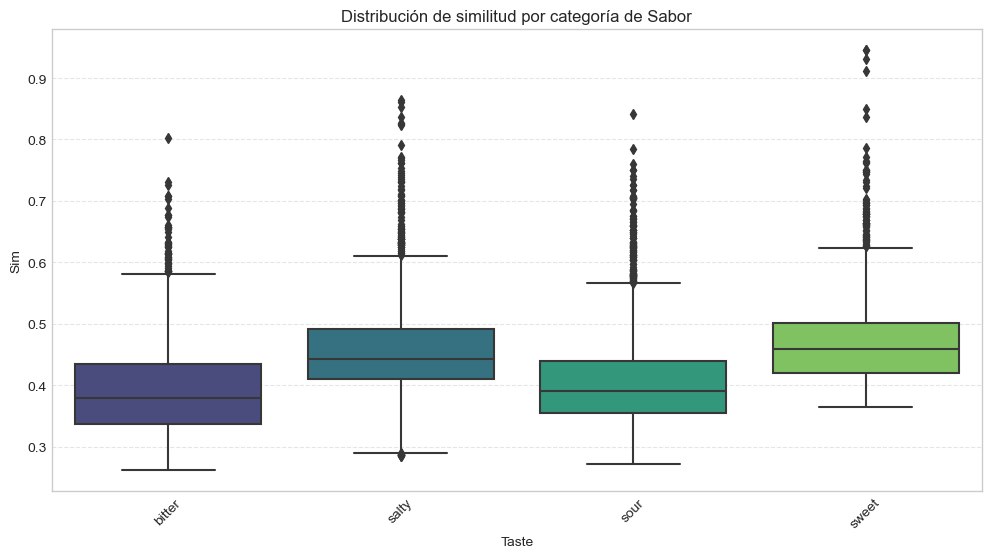

In [32]:


# Asegurar que taste no tenga valores nulos
df_plot = merged_food.dropna(subset=['taste'])
df_plot=df_plot[df_plot['taste']!='No Label']
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_plot,
    x='taste',
    y='sim',
    palette="viridis"
)

plt.title("Distribución de similitud por categoría de Sabor")
plt.xlabel("Taste")
plt.ylabel("Sim")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [33]:
# Crear una columna con los deciles de similitud
df_plot['sim_decile'], bins = pd.qcut(df_plot['sim'], q=10, labels=False, retbins=True)

# Calcular tabla de frecuencias por taste y por decil
tabla_frecuencias = (
    df_plot.groupby(['taste', 'sim_decile'])
           .size()
           .reset_index(name='count')
           .pivot(index='taste', columns='sim_decile', values='count')
           .fillna(0)
)

# Renombrar columnas para mayor claridad
tabla_frecuencias.columns = [f"Decil {d+1}" for d in tabla_frecuencias.columns]

tabla_frecuencias
intervalos_texto = [f"({bins[i]:.4f}, {bins[i+1]:.4f}]" for i in range(len(bins)-1)]

# Crear DataFrame fila
fila_intervalos = pd.DataFrame([intervalos_texto], 
                               index=["Intervalo"],
                               columns=tabla_frecuencias.columns)

# Agregarla debajo de la tabla
tabla_con_intervalos = pd.concat([tabla_frecuencias, fila_intervalos])

In [34]:
tabla_con_intervalos

,Decil 1,Decil 2,Decil 3,Decil 4,Decil 5,Decil 6,Decil 7,Decil 8,Decil 9,Decil 10
bitter,418.0,322.0,239.0,183.0,129.0,105.0,127.0,103.0,79.0,95.0
salty,64.0,69.0,104.0,165.0,192.0,258.0,276.0,206.0,248.0,218.0
sour,238.0,316.0,270.0,239.0,160.0,132.0,107.0,105.0,63.0,170.0
sweet,0.0,14.0,106.0,134.0,238.0,226.0,209.0,306.0,330.0,237.0
Intervalo,"(0.2613, 0.3331]","(0.3331, 0.3692]","(0.3692, 0.3855]","(0.3855, 0.4043]","(0.4043, 0.4225]","(0.4225, 0.4402]","(0.4402, 0.4622]","(0.4622, 0.4888]","(0.4888, 0.5340]","(0.5340, 0.9449]"


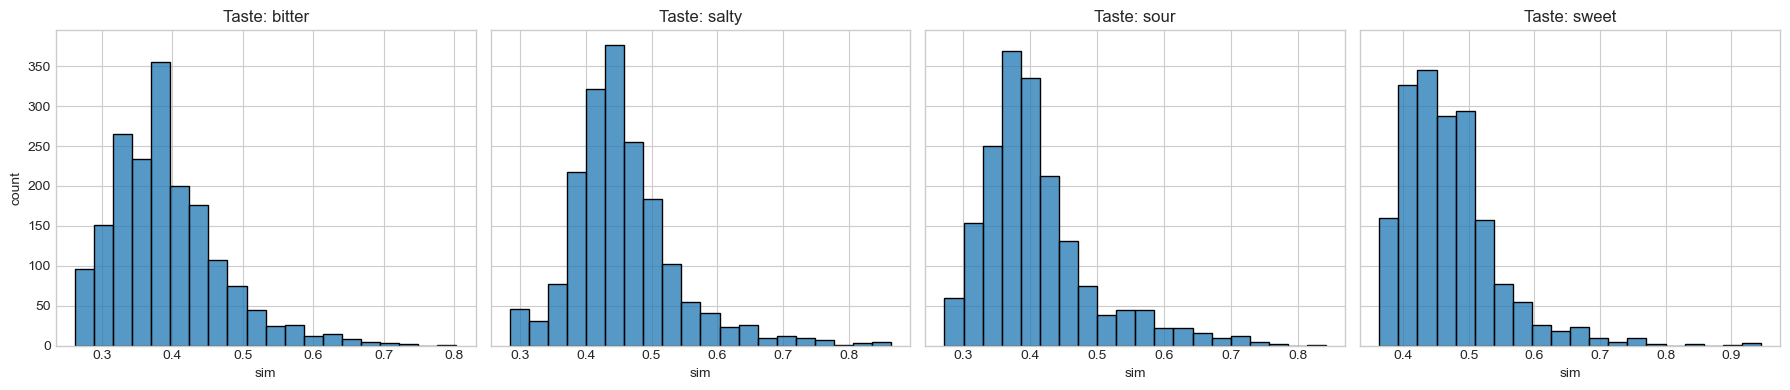

In [35]:
tastes = df_plot['taste'].dropna().unique()

# Crear figura con 4 subplots (1 fila, 4 columnas)
fig, axes = plt.subplots(1, len(tastes), figsize=(18, 4), sharey=True)

for ax, taste in zip(axes, tastes):
    subset = df_plot[df_plot['taste'] == taste]
    sns.histplot(subset['sim'], bins=20, ax=ax)
    ax.set_title(f"Taste: {taste}")
    ax.set_xlabel("sim")
    ax.set_ylabel("count")

plt.tight_layout()
plt.show()

### Resultados por prompt

In [36]:
merged_prompt.groupby('taste').agg({'sim':['mean', 'max', 'min', 'median', 'std'], 'food_item': 'count'}).reset_index()

taste       sim                                         food_item
               mean       max       min    median       std     count
0  bitter  0.309597  0.607745  0.203286  0.304952  0.054536      1800
1   salty  0.339711  0.614100  0.232898  0.337241  0.052303      1800
2    sour  0.332547  0.632830  0.211157  0.328789  0.053932      1800
3   sweet  0.343515  0.725170  0.227098  0.334567  0.058282      1800

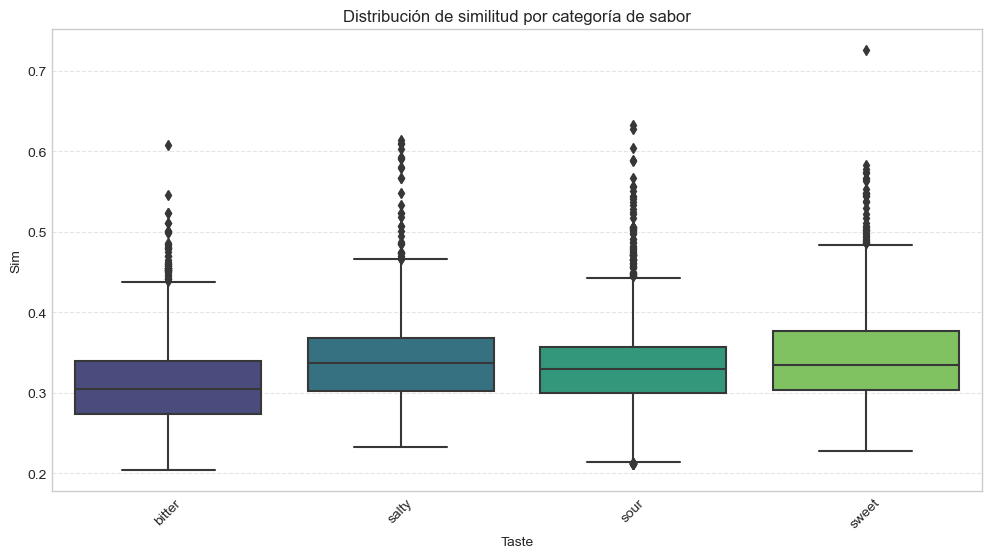

In [37]:
df_plot = merged_prompt.dropna(subset=['taste'])
df_plot=df_plot[df_plot['taste']!='No Label']
#df_plot=df_plot[df_plot['rank_sim']<=10]
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_plot, x='taste', y='sim', palette="viridis")

plt.title("Distribución de similitud por categoría de sabor")
plt.xlabel("Taste")
plt.ylabel("Sim")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [38]:
# Crear una columna con los deciles de similitud
df_plot['sim_decile'], bins = pd.qcut(df_plot['sim'], q=10, labels=False, retbins=True)

# Calcular tabla de frecuencias por taste y por decil
tabla_frecuencias = (
    df_plot.groupby(['taste', 'sim_decile'])
           .size()
           .reset_index(name='count')
           .pivot(index='taste', columns='sim_decile', values='count')
           .fillna(0)
)

# Renombrar columnas para mayor claridad
tabla_frecuencias.columns = [f"Decil {d+1}" for d in tabla_frecuencias.columns]

tabla_frecuencias
intervalos_texto = [f"({bins[i]:.4f}, {bins[i+1]:.4f}]" for i in range(len(bins)-1)]

# Crear DataFrame fila
fila_intervalos = pd.DataFrame([intervalos_texto], 
                               index=["Intervalo"],
                               columns=tabla_frecuencias.columns)

# Agregarla debajo de la tabla
tabla_con_intervalos = pd.concat([tabla_frecuencias, fila_intervalos])

## Métricas adicionales

Adicional a metericas descriptivas, se realizó un análisis con métricas como overlap@100, la correlacion de similitudes, la correlación de spearman, unique_rate@100, ademas de la dispersión de las recuperaciones con respecto a sus posiciones dentro del top 100.

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Renombramos columnas para evitar colisiones
prompt_df = merged_prompt.rename(columns={
    "sim": "sim_prompt",
    "rank_sim": "rank_prompt"
})

food_df = merged_food.rename(columns={
    "sim": "sim_food",
    "rank_sim": "rank_food"
})

# Merge por id + food_item, mantenemos 'taste'
df = prompt_df.merge(
    food_df,
    on=["id", "food_item"],
    how="inner",
    suffixes=("_prompt", "_food")
)

# ----------------------------------------------------
# Funciones auxiliares
# ----------------------------------------------------

def overlap_at_k_by_taste(prompt_df, food_df, k=20):
    results = []

    for taste, g_prompt in prompt_df.groupby("taste"):
        g_food = food_df[food_df["taste"] == taste]

        overlaps = []

        for q in g_prompt["id"].unique():
            top_prompt = (
                g_prompt[g_prompt["id"] == q]
                .sort_values("rank_prompt")
                .head(k)["food_item"]
            )

            top_food = (
                g_food[g_food["id"] == q]
                .sort_values("rank_food")
                .head(k)["food_item"]
            )

            if len(top_food) > 0:
                overlap = len(set(top_prompt) & set(top_food)) / k
                overlaps.append(overlap)

        results.append({
            "taste": taste,
            "overlap@20": sum(overlaps) / len(overlaps) if overlaps else None
        })

    return pd.DataFrame(results)


def similarity_corr_by_taste(df):
    results = []

    for taste, g in df.groupby("taste_prompt"):
        corrs = g.groupby("id").apply(
            lambda x: x["sim_prompt"].corr(x["sim_food"])
        )
        results.append({
            "taste": taste,
            "similarity_corr": corrs.mean()
        })

    return pd.DataFrame(results)


def spearman_by_taste(df):
    results = []

    for taste, g in df.groupby("taste_prompt"):
        rho_values = []
        for q, gq in g.groupby("id"):
            rho, _ = spearmanr(gq["rank_prompt"], gq["rank_food"])
            rho_values.append(rho)

        results.append({
            "taste": taste,
            "spearman": pd.Series(rho_values).mean()
        })

    return pd.DataFrame(results)




overlap_df = overlap_at_k_by_taste(prompt_df, food_df, k=100)
simcorr_df = similarity_corr_by_taste(df)
spearman_df = spearman_by_taste(df)

# Resultado final agrupado por taste
results_taste = overlap_df.merge(simcorr_df, on="taste").merge(spearman_df, on="taste")

print(results_taste)


    taste  overlap@20  similarity_corr  spearman
0  bitter    0.458889         0.591499  0.374918
1   salty    0.525556         0.639221  0.470517
2    sour    0.482222         0.607855  0.492843
3   sweet    0.543889         0.628920  0.420699


In [39]:
def unique_rate_by_taste(df, taste_col="taste", item_col="food_item", query_col="id", k=20):
    """Calcula unique rate@k por categoría de taste."""

    resultados = []

    for taste, grupo in df.groupby(taste_col):

        # Agrupar por cada query (prompt o food item)
        unique_rates = []

        for qid, g in grupo.groupby(query_col):

            # Tomar el top-k
            top_k = g[item_col].head(k)

            # unique rate = (# únicos / k)
            ur = top_k.nunique() / k
            unique_rates.append(ur)

        resultados.append({
            "taste": taste,
            f"unique_rate@{k}": sum(unique_rates) / len(unique_rates)
        })

    return pd.DataFrame(resultados)


# EJEMPLO DE USO
unique_prompt = unique_rate_by_taste(merged_prompt, k=100)
unique_food = unique_rate_by_taste(merged_food, k=100)

print("Unique Rate por taste (PROMPT):")
print(unique_prompt)

print("\nUnique Rate por taste (FOOD):")
print(unique_food)

Unique Rate por taste (PROMPT):
    taste  unique_rate@100
0  bitter              1.0
1   salty              1.0
2    sour              1.0
3   sweet              1.0

Unique Rate por taste (FOOD):
    taste  unique_rate@100
0  bitter              1.0
1   salty              1.0
2    sour              1.0
3   sweet              1.0


In [48]:
def topk_frequency(df, item_col="food_item", k=20):
    """
    Cuenta cuántas veces aparece cada food_item dentro del top-k
    en todas las recuperaciones del dataset.
    """
    # Tomar solo top-k por cada query (prompt o food)
    df_topk = df.groupby("id").head(k)

    freq = (
        df_topk[item_col]
        .value_counts()
        .reset_index()
        .rename(columns={"index": item_col, item_col: "frequency"})
    )

    return freq

freq_prompt = topk_frequency(merged_prompt, k=100)
freq_food   = topk_frequency(merged_food, k=100)

print("Top 10 frecuentes (PROMPT):")
print(freq_prompt.head(10))

print("\nTop 10 frecuentes (FOOD):")
print(freq_food.head(10))

Top 10 frecuentes (PROMPT):
                   frequency  count
0      fruit cocktail canned     36
1                 ginger ale     35
2             cocktail sauce     35
3  vanilla bluberry bar kind     32
4                 wine light     31
5              mint lemonade     31
6     pineapple orange juice     29
7     orange pineapple juice     28
8             coffee liqueur     28
9        cinnamon coffeecake     28

Top 10 frecuentes (FOOD):
         frequency  count
0  tangerine juice     27
1    gazpacho soup     25
2             cola     25
3  vanilla pudding     24
4  vegetable juice     24
5    fruit burrito     24
6     orange juice     24
7       lime juice     23
8    banana pepper     22
9  pineapple juice     22


In [49]:
def average_rank(df, item_col="food_item"):
    """
    Calcula el promedio de la posición (rank) en que aparece cada food_item.
    Posiciones pequeñas = aparece en lugares altos.
    """
    df["rank"] = df.groupby("id").cumcount() + 1

    avg_rank = (
        df.groupby(item_col)["rank"]
          .mean()
          .reset_index()
          .sort_values("rank")
    )
    return avg_rank

avg_rank_prompt = average_rank(merged_prompt)
avg_rank_food   = average_rank(merged_food)

print("Ítems con menor rank promedio (PROMPT):")
print(avg_rank_prompt.head(10))

print("\nÍtems con menor rank promedio (FOOD):")
print(avg_rank_food.head(10))


Ítems con menor rank promedio (PROMPT):
                                  food_item  rank
1137        whey protein powder vanilla eas   1.0
512                            greek yogurt   1.0
504                     grape leaves canned   2.0
517                    green soybean cooked   2.0
1081  triple zero greek yogurt dannon oikos   2.5
592                         kohlrabi cooked   3.0
975                               soy sauce   3.0
660                                    miso   4.0
551             honey cereali general mills   5.0
821                      popcorn oil popped   6.0

Ítems con menor rank promedio (FOOD):
                       food_item  rank
921                       quince   1.0
870           popcorn oil popped   2.0
10          american shad cooked   2.0
930              rambutan canned   3.0
868           popcorn air popped   3.0
591                     horchata   4.0
745                    olive oil   4.0
972            salat mix alestro   5.0
173  caesar dressing

## Conclusiones:
En primer lugar, el análisis de las distribuciones de similitud revela que los primeros nueve deciles presentan intervalos estrechos y concentrados, lo que indica que la mayoría de las recuperaciones se sitúan en regiones bien delimitadas del espacio semántico. Sin embargo, el intervalo correspondiente al decil superior muestra una amplitud considerablemente mayor en ambos escenarios. Esta característica es especialmente marcada cuando la consulta se origina en un alimento, donde los valores máximos alcanzan similitudes cercanas a 0.94. La presencia de un intervalo tan amplio en lo más alto de la distribución sugiere que los elementos con mayor similitud no conforman un clúster compacto, sino que se encuentran dispersos en distintas zonas del espacio de representación. Este comportamiento indica que el modelo identifica múltiples regiones altamente relevantes, lo cual refleja una estructura semántica rica y heterogénea en las consultas basadas en alimentos.

En contraste, las consultas basadas en prompts presentan un decil superior con un intervalo menos extendido, lo que sugiere una menor dispersión en las recuperaciones más similares. Este patrón puede asociarse a la variabilidad semántica y a la menor especificidad semántica de los prompts, que tienden a restringir el espacio de representación a zonas más acotadas.

Las métricas de consistencia entre recuperaciones basadas en alimentos y en prompts muestran que las categorías sweet y salty exhiben los valores más altos de Overlap@100 y correlación de similitud, lo que indica una mayor estabilidad en las recuperaciones asociadas a estos sabores. Por su parte, sour destaca por mantener el ordenamiento más coherente entre ambas fuentes de consulta, mientras que la categoría bitter presenta los valores más bajos en todas las métricas, sugiriendo mayor variabilidad y una estructura semántica menos estable.

El análisis del Unique Rate@100 confirma que los embeddings preservan un nivel adecuado de diversidad, ya que en todos los casos las recuperaciones contienen exclusivamente elementos únicos. Esta consistencia se observa tanto en consultas basadas en prompts como en consultas basadas en alimentos, lo que indica ausencia de colapso representacional y una adecuada dispersión del espacio de vecinos cercanos.

Finalmente, el estudio de recurrencias y posiciones promedio dentro del top–100 no evidenció comportamientos de dominancia ni sesgos estructurales hacia subconjuntos específicos de ítems. Aunque algunos elementos aparecen con mayor frecuencia, esta recurrencia no afecta la diversidad global de las recuperaciones ni su distribución en el espacio de representación.

En conjunto, los resultados muestran que el sistema de recuperación mantiene un comportamiento estable, diverso y sin sesgos marcados. Las consultas basadas en alimentos generan regiones semánticas más amplias y dispersas en los valores altos de similitud, mientras que las consultas textuales operan dentro de rangos más acotados. Estas diferencias reflejan la naturaleza complementaria de ambos tipos de entrada y sugieren que el modelo captura adecuadamente la variabilidad semántica presente en la base de datos crossmodal. 